In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense
from keras.datasets import mnist
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


# 資料整理

In [2]:
(X_train,Y_train), (X_test,Y_test) = mnist.load_data()

print("X_train.shape =", X_train.shape)
print("X_test.shape =", X_test.shape)

X_train.shape = (60000, 28, 28)
X_test.shape = (10000, 28, 28)


In [3]:
x_train = X_train.reshape(60000, -1)
x_train = (x_train-x_train.min())/x_train.max()

x_test = X_test.reshape(10000, -1)
x_test = (x_test-x_test.min())/x_test.max()

print(x_train.min(), x_train.max(), sep='\n', end='\n\n')
print(x_test.min(), x_test.max(), sep='\n')

0.0
1.0

0.0
1.0


# 用 Functional API 打造 VAE

In [4]:
def sampling(args):
    μ, s = args
    return μ + K.exp(s/2) * K.tf.random_normal(shape=(2,), mean=0, stddev=1)

Enc1 = Dense(100, activation='sigmoid')
Enc_mean = Dense(2)
Enc_log_var = Dense(2)
sample_layer = Lambda(sampling, output_shape=(2,))
Dec1 = Dense(100, activation='sigmoid')
Dec2 = Dense(784, activation='sigmoid')

x = Input(shape=(784,))
h_mean = Enc_mean(Enc1(x))
h_log_var = Enc_log_var(Enc1(x))
h = [h_mean, h_log_var]
x_hat = Dec2(Dec1(sample_layer(h)))

VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[1][0]                    
__________

In [5]:
def vae_loss(x, x_hat):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_hat)
    kl_loss = -0.5 * K.sum(1 + h_log_var - K.square(h_mean) - K.exp(h_log_var), axis=-1)
    return recovery_loss + kl_loss

VAE.compile(loss=vae_loss, optimizer='adam')
VAE.fit(x_train, x_train, batch_size=50, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 9s 153us/step - loss: 200.6029
Epoch 2/100
60000/60000 [==============================] - 10s 159us/step - loss: 181.4245
Epoch 3/100
60000/60000 [==============================] - 10s 168us/step - loss: 179.8688
Epoch 4/100
60000/60000 [==============================] - 10s 168us/step - loss: 178.4420
Epoch 5/100
60000/60000 [==============================] - 8s 139us/step - loss: 176.3480
Epoch 6/100
60000/60000 [==============================] - 8s 137us/step - loss: 173.5955
Epoch 7/100
60000/60000 [==============================] - 8s 137us/step - loss: 170.9623
Epoch 8/100
60000/60000 [==============================] - 8s 137us/step - loss: 168.8528
Epoch 9/100
60000/60000 [==============================] - 8s 136us/step - loss: 167.1544
Epoch 10/100
60000/60000 [==============================] - 8s 139us/step - loss: 165.8845
Epoch 11/100
60000/60000 [==============================] - 8s 138us/step - loss: 164.7373
Epoch

60000/60000 [==============================] - 8s 137us/step - loss: 145.6245
Epoch 91/100
60000/60000 [==============================] - 9s 149us/step - loss: 145.5363
Epoch 92/100
60000/60000 [==============================] - 10s 161us/step - loss: 145.4699
Epoch 93/100
60000/60000 [==============================] - 9s 157us/step - loss: 145.4031
Epoch 94/100
60000/60000 [==============================] - 11s 181us/step - loss: 145.2956
Epoch 95/100
60000/60000 [==============================] - 10s 159us/step - loss: 145.2761
Epoch 96/100
60000/60000 [==============================] - 10s 164us/step - loss: 145.2245
Epoch 97/100
60000/60000 [==============================] - 10s 169us/step - loss: 145.2456
Epoch 98/100
60000/60000 [==============================] - 10s 173us/step - loss: 145.2700
Epoch 99/100
60000/60000 [==============================] - 10s 163us/step - loss: 145.0896
Epoch 100/100
60000/60000 [==============================] - 10s 159us/step - loss: 145.0633


# 取出 Encoder 和 Decoder

In [6]:
Encoder = Model(x, h_mean)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [7]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, Dec2(Dec1(h_input)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


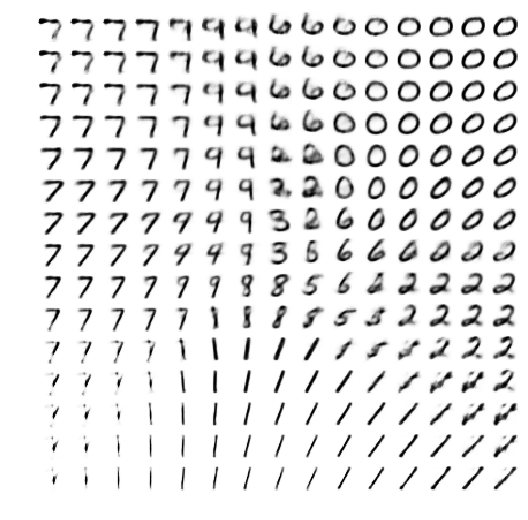

In [8]:
n = 15
figures = np.zeros((28*n, 28*n))
grid_x = np.linspace(-4+0.05, 4-0.05, n)
grid_y = np.linspace(-4+0.05, 4-0.05, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        h_sample = np.array([[xi,yi]])
        x_decoded = Decoder.predict(h_sample)
        digit = (x_decoded.reshape(28,28) - x_decoded.min()) / x_decoded.max()
        figures[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = digit

plt.figure(figsize=(8,8), dpi=80)
plt.imshow(figures, cmap='Greys')
plt.axis('off')
plt.show()

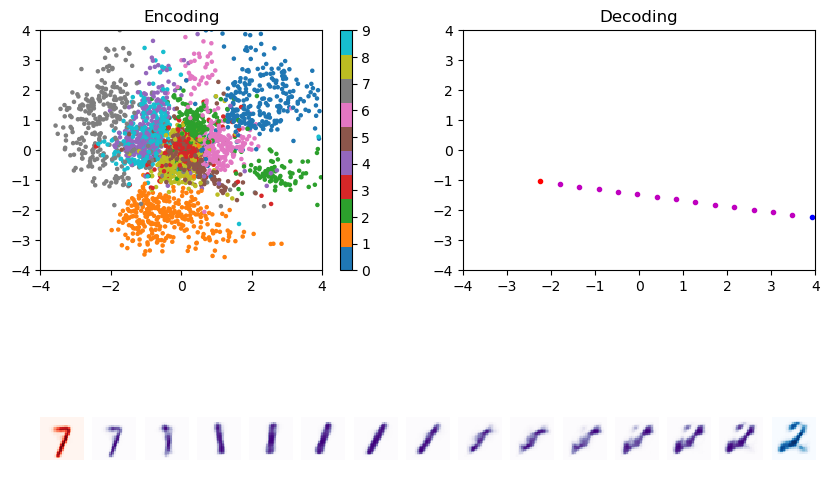

In [11]:
plt.figure(figsize=(10,7), dpi=100)

indices = np.random.choice(x_test.shape[0], size=3000, replace=False)
lats = Encoder.predict(x_test[indices])

plt.subplot(2,2,1)
plt.scatter(lats[:,0], lats[:,1], c=Y_test[indices], cmap="tab10", s=5)
plt.title('Encoding')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.colorbar().set_ticks(range(10))

a, b = -4 + 8*np.random.rand(2,2)
points = np.zeros((15,2))
points += a + np.arange(15).reshape(15,1)*(b-a)/14

plt.subplot(2,2,2)
plt.plot(points[0,0], points[0,1], 'r.')
plt.plot(points[1:-1,0], points[1:-1,1], 'm.')
plt.plot(points[-1,0], points[-1,1], 'b.')
plt.title('Decoding')
plt.xlim(-4,4)
plt.ylim(-4,4)

points_decoded = Decoder.predict(points)
for i in range(15):
    fig = (points_decoded[i].reshape(28,28) - points_decoded[i].min()) / points_decoded[i].max()
    plt.subplot(2,15,i+16)
    if i==0:
        plt.imshow(fig, cmap='Reds')
    elif i==14:
        plt.imshow(fig, cmap='Blues')
    else:
        plt.imshow(fig, cmap='Purples')
    plt.axis('off')

plt.show()